<a href="https://colab.research.google.com/github/chrisrichardson/minidolfin/blob/master/minidolfin_helmholtz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install libraries
!pip3 install numba>=0.49 --upgrade
!pip3 install pyamg
!pip3 -q install git+https://github.com/FEniCS/FIAT.git --upgrade
!pip3 -q install git+https://github.com/FEniCS/ufl.git --upgrade
!pip3 -q install git+https://github.com/FEniCS/ffcx.git --upgrade
!pip3 -q install git+https://github.com/chrisrichardson/minidolfin.git --upgrade

     |████████████████████████████████| 6.4MB 2.5MB/s 
     |████████████████████████████████| 296kB 35.7MB/s 
     |████████████████████████████████| 153kB 2.8MB/s 


In [3]:
import numba
numba.__version__

'0.51.2'

__Helmholtz equation__

In this demo, we will solve the Helmholtz equation $\nabla^2 u - \omega^2 u = 0$ subject to enforced boundary conditions on all edges of a square domain. The wavenumber $\omega$ may be complex, resulting in a decaying wave on the interior.

In [5]:
import ufl
import numpy
import scipy.sparse.linalg
 
from minidolfin.meshing import build_unit_square_mesh
from minidolfin.dofmap import build_dofmap
from minidolfin.dofmap import interpolate_vertex_values
from minidolfin.assembling import assemble
from minidolfin.bcs import build_dirichlet_dofs
from minidolfin.bcs import bc_apply
 
# Wavenumber squared                                                                 
omega2 = (15**2 + 40**2) - 50j
 
 
def u_exact(x):
    return numpy.exp(-15j*x[0] + 40j*x[1])
 
 
# UFL form                                                                      
element = ufl.FiniteElement("P", ufl.triangle, 1)
u, v = ufl.TrialFunction(element), ufl.TestFunction(element)
a = (ufl.inner(ufl.grad(u), ufl.grad(v)) - omega2*ufl.inner(u, v))*ufl.dx
 
# Build mesh                                                                    
mesh = build_unit_square_mesh(80, 80)
tdim = mesh.reference_cell.get_dimension()
print('Number cells: {}'.format(mesh.num_entities(tdim)))
 
# Build dofmap                                                                  
dofmap = build_dofmap(element, mesh)
print('Number dofs: {}'.format(dofmap.dim))
 
# Run and time assembly                                                       
A = assemble(dofmap, a, dtype=numpy.complex128)
 
# Prepare solution and rhs vectors and apply boundary conditions
x = numpy.zeros(A.shape[1], dtype=A.dtype)
b = numpy.zeros(A.shape[0], dtype=A.dtype)
 
# Set Dirichlet BCs
bc_dofs, bc_vals = build_dirichlet_dofs(dofmap, u_exact, dtype=A.dtype)
 
print(bc_vals.dtype)
bc_apply(bc_dofs, bc_vals, A, b)
 
# Solve linear system
x = scipy.sparse.linalg.spsolve(A, b)
 
r = (A*x - b)
print(r.max(), r.min())

Number cells: 12800
Number dofs: 6561
complex128
(1.992850329202156e-14+3.7636560534792807e-14j) (-2.6645352591003757e-14-8.837375276016246e-14j)


__Visualisation I__

Plot the real and imaginary parts of the solution.

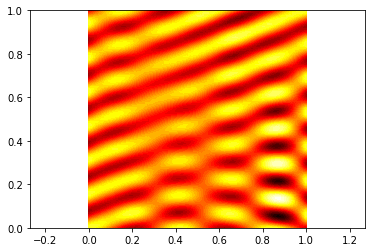

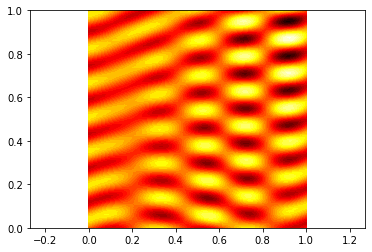

In [6]:
%matplotlib inline
from matplotlib import tri
import matplotlib.pyplot as plt
 
# Plot solution
vertex_values = interpolate_vertex_values(dofmap, x)
triang = tri.Triangulation(mesh.vertices[:, 0], mesh.vertices[:, 1],
                           mesh.get_connectivity(tdim, 0))
plt.axis('equal')
plt.tricontourf(triang, numpy.real(vertex_values), 40, cmap='hot')
plt.show()
plt.axis('equal')
plt.tricontourf(triang, numpy.imag(vertex_values), 40, cmap='hot')
plt.show()

__Visualisation II__

Now for some fun animation, just rotate the solution by $e^{i\theta}$ on each timestep.

In [7]:
%%capture
from matplotlib import animation, rc
from IPython.display import HTML
import numpy as np
fig = plt.figure()
ax = fig.add_subplot(111)
plt.axis('equal')
 
def animate(i):
    ax.collections = []
    global triang, vertex_values
    vertex_values *= numpy.exp(1j*np.pi/10)
    plot = plt.tripcolor(triang, numpy.real(vertex_values), cmap='hot');
    return (plot,)
 
anim = animation.FuncAnimation(fig, animate,
                               frames=20, interval=80, 
                               blit=True)
anim = anim.to_jshtml()

In [8]:
HTML(anim)